# RNAome Experiment (Fig 4B)

We run the non-redundant set of RNAs through ARES, and capture the embedding at the penultimate layer.  We then run PCA clustering on this embedding to assess if meaningful features of RNA are captured.

RNA features were calculated using x3dna v2.4

Pdbs are available at https://purl.stanford.edu/bn398fc4306 under `rnaome/pdbs`.

x3dna outputs are available under `data/*.json`.

ARES prediction and embeddings are at `rnaome.csv`.

In [1]:
import os
import glob
import json
import collections as col

import numpy as np
import pandas as pd

from sklearn import decomposition
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [2]:
# Read in ARES embeddings.
df = pd.read_csv('new_rnaome.csv')

In [3]:
# PCA, if we want to recompute.
pca = decomposition.PCA(random_state=3241)
data = df[['fe{}'.format(x) for x in range(256)]]
Y_pca = pca.fit_transform(data)
df['y_pca0'] = Y_pca[:,0]
df['y_pca1'] = Y_pca[:,1]
df['y_pca2'] = Y_pca[:,2]
df['y_pca3'] = Y_pca[:,3]

In [4]:
# Extract precomputed x3dna features.
to_use = ['num_nts', 'num_helices', 'num_stems', 'num_hbonds', 'num_stacks',
          'num_ssSegments', 'num_splayUnits', 'num_pairs', 'num_hairpins',
          'num_atom2bases', 'num_Aminors', 'num_bulges', 'num_coaxStacks',
         'num_iloops', 'num_isoCanonPairs', 'num_junctions', 'num_multiplets']

entries = col.defaultdict(list)

for file in glob.glob('data/*.json'):
    name = os.path.basename(file).split('.')[0]
    with open(file, 'r') as f:
        tmp = json.load(f)
        for x in to_use:
            if x in tmp:
                entries[x].append(tmp[x])
            else:
                entries[x].append(0)
            
        entries['name'].append(name)
        if 'pairs' in tmp:
            entries['num_WC'].append(len([x for x in tmp['pairs'] if x['LW'] == 'cWW']))
        else:
            entries['num_WC'].append(0)
        for code in ['A', 'C', 'G', 'U']:
            entries['num_{:}'.format(code)] = len([x for x in tmp['nts'] if x['nt_code'] == code])
        entries['num_{:}'.format('GC')] = len([x for x in tmp['nts'] if x['nt_code'] in ['G', 'C']])
entries = pd.DataFrame(entries)

to_use += ['num_WC', 'num_A', 'num_C', 'num_G', 'num_U', 'num_GC']

for x in to_use:
    entries[x + '_norm_nts'] = 1.0 * entries[x] / entries['num_nts']
    entries[x + '_norm_pairs'] = 1.0 * entries[x] / entries['num_pairs']

final = pd.merge(entries, df, left_on='name', right_on='tag')

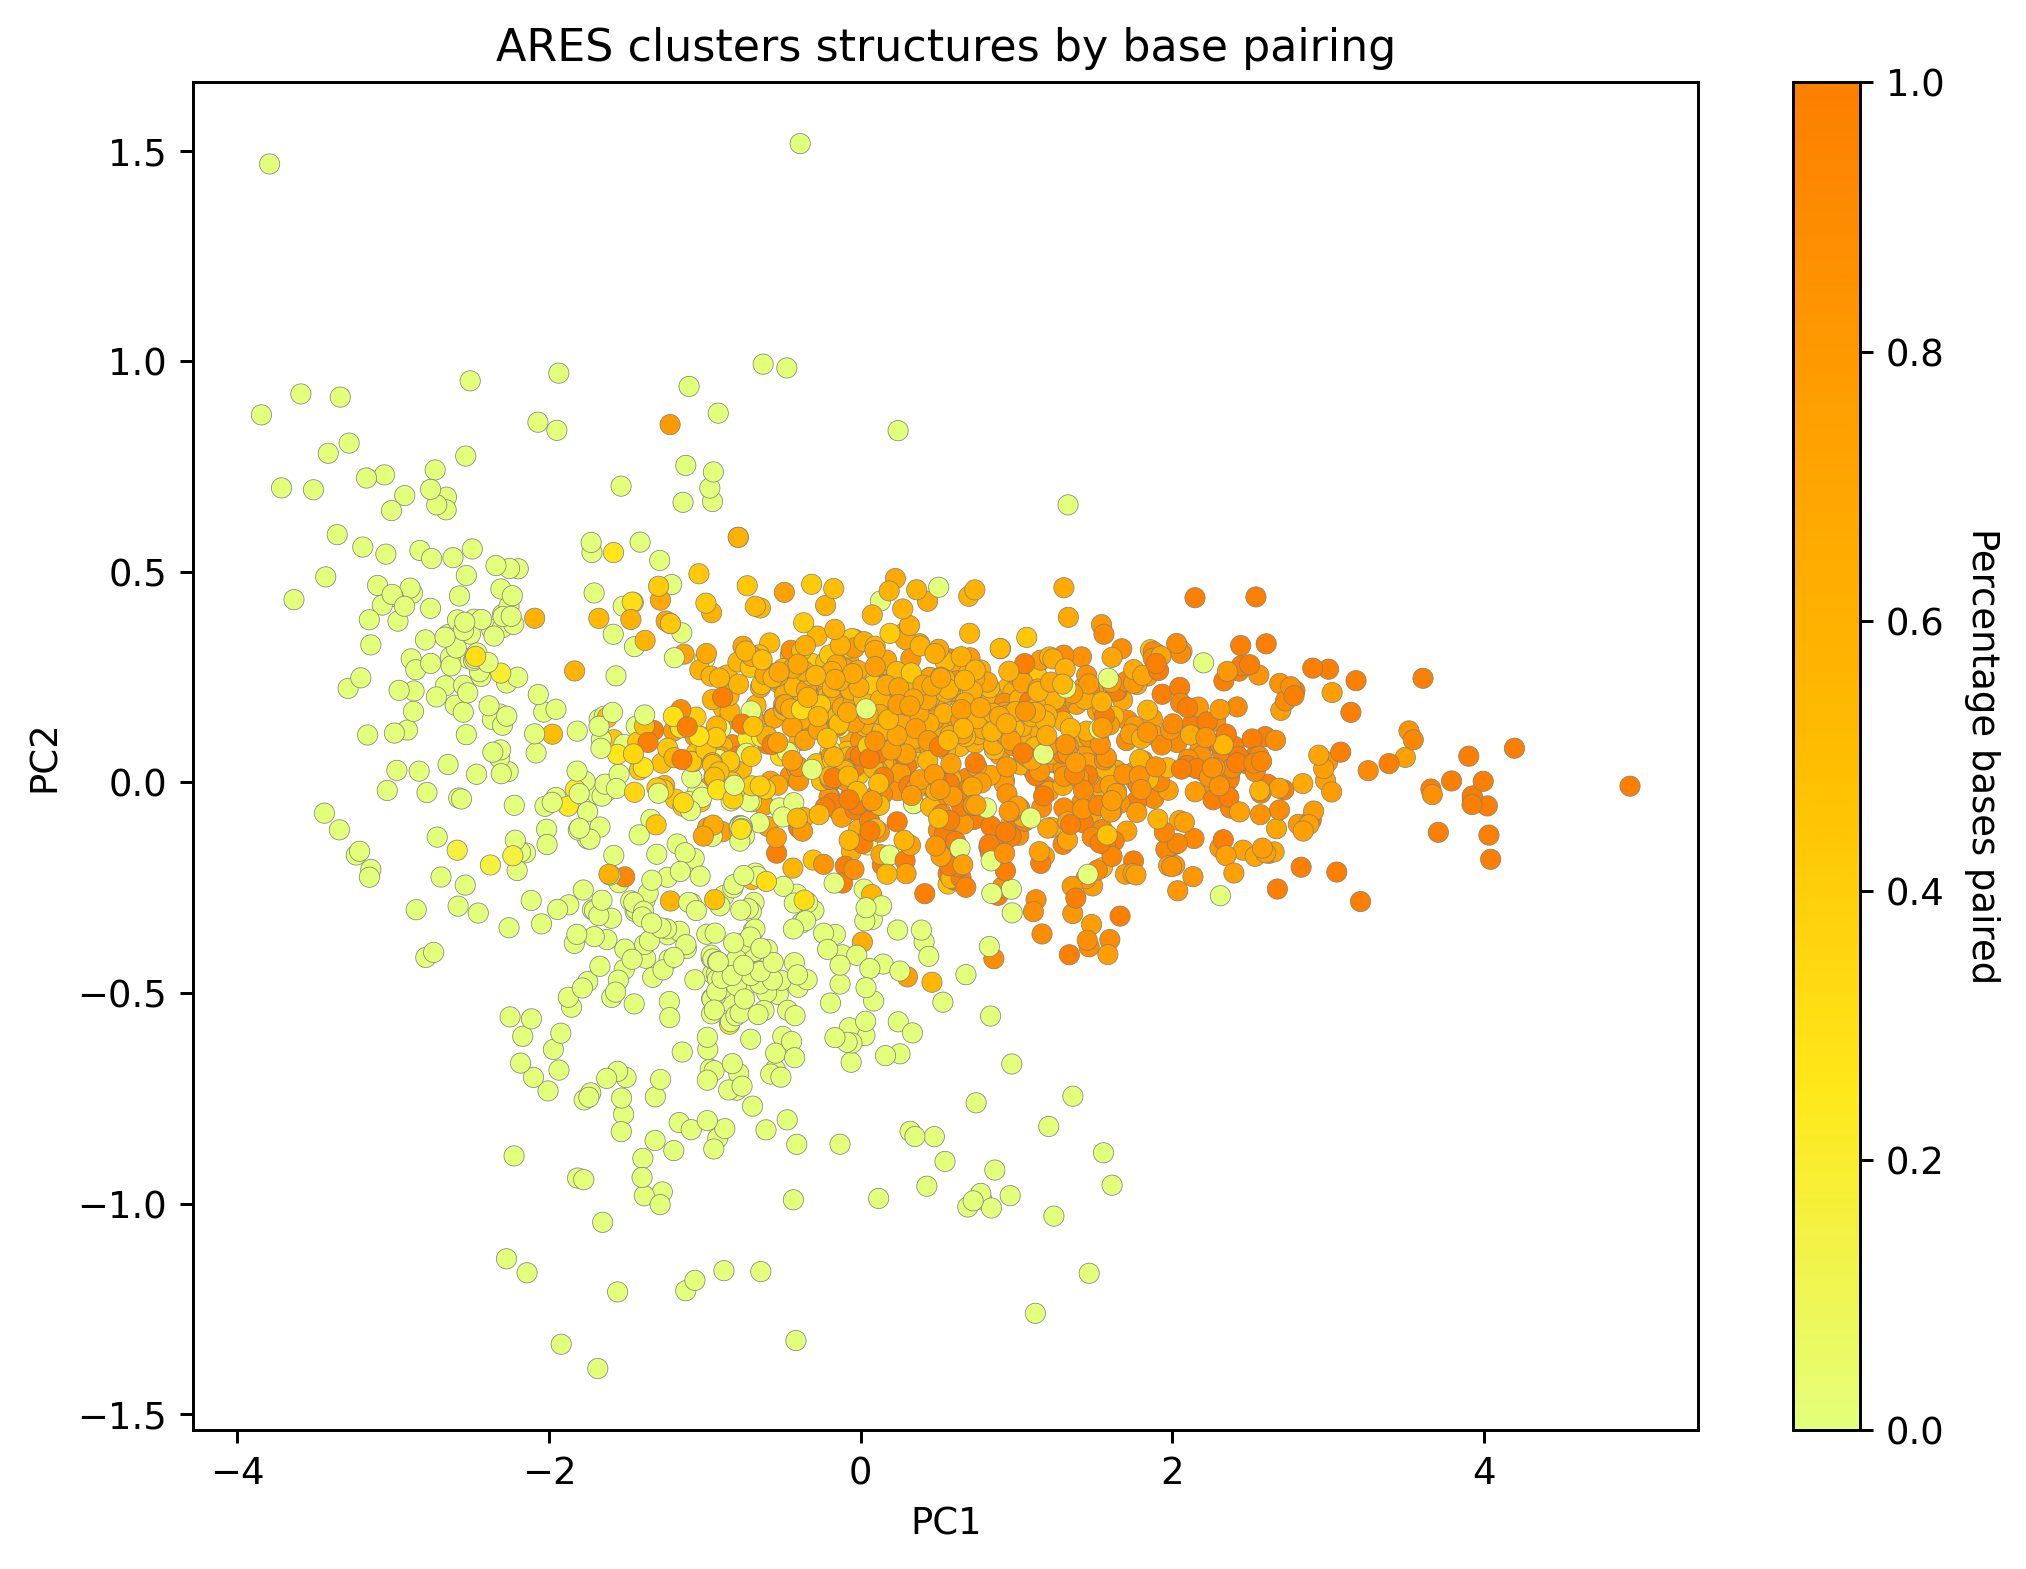

In [5]:
# Plot base pairing PCA.
(x, y, z) = ('y_pca0', 'y_pca1', 'num_WC_norm_nts')

cmap = cm.get_cmap('Wistia')
norm = plt.Normalize(0, 1)

sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
fig = plt.figure(figsize=(8, 6), dpi=266)
ax = plt.gca()
fig.patch.set_alpha(0)

ax.scatter(x=final['y_pca0'], y=final['y_pca1'], 
           s=30, c=2 * final[z], 
           cmap=cmap, norm=norm, ec='grey', lw=0.2)
    
ax.tick_params(labelsize=10)
cbar = plt.colorbar(sm, ax=ax)
cbar.ax.get_yaxis().labelpad = 15
cbar.set_label('Percentage bases paired', rotation=270)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

plt.title('ARES clusters structures by base pairing')

plt.tight_layout()

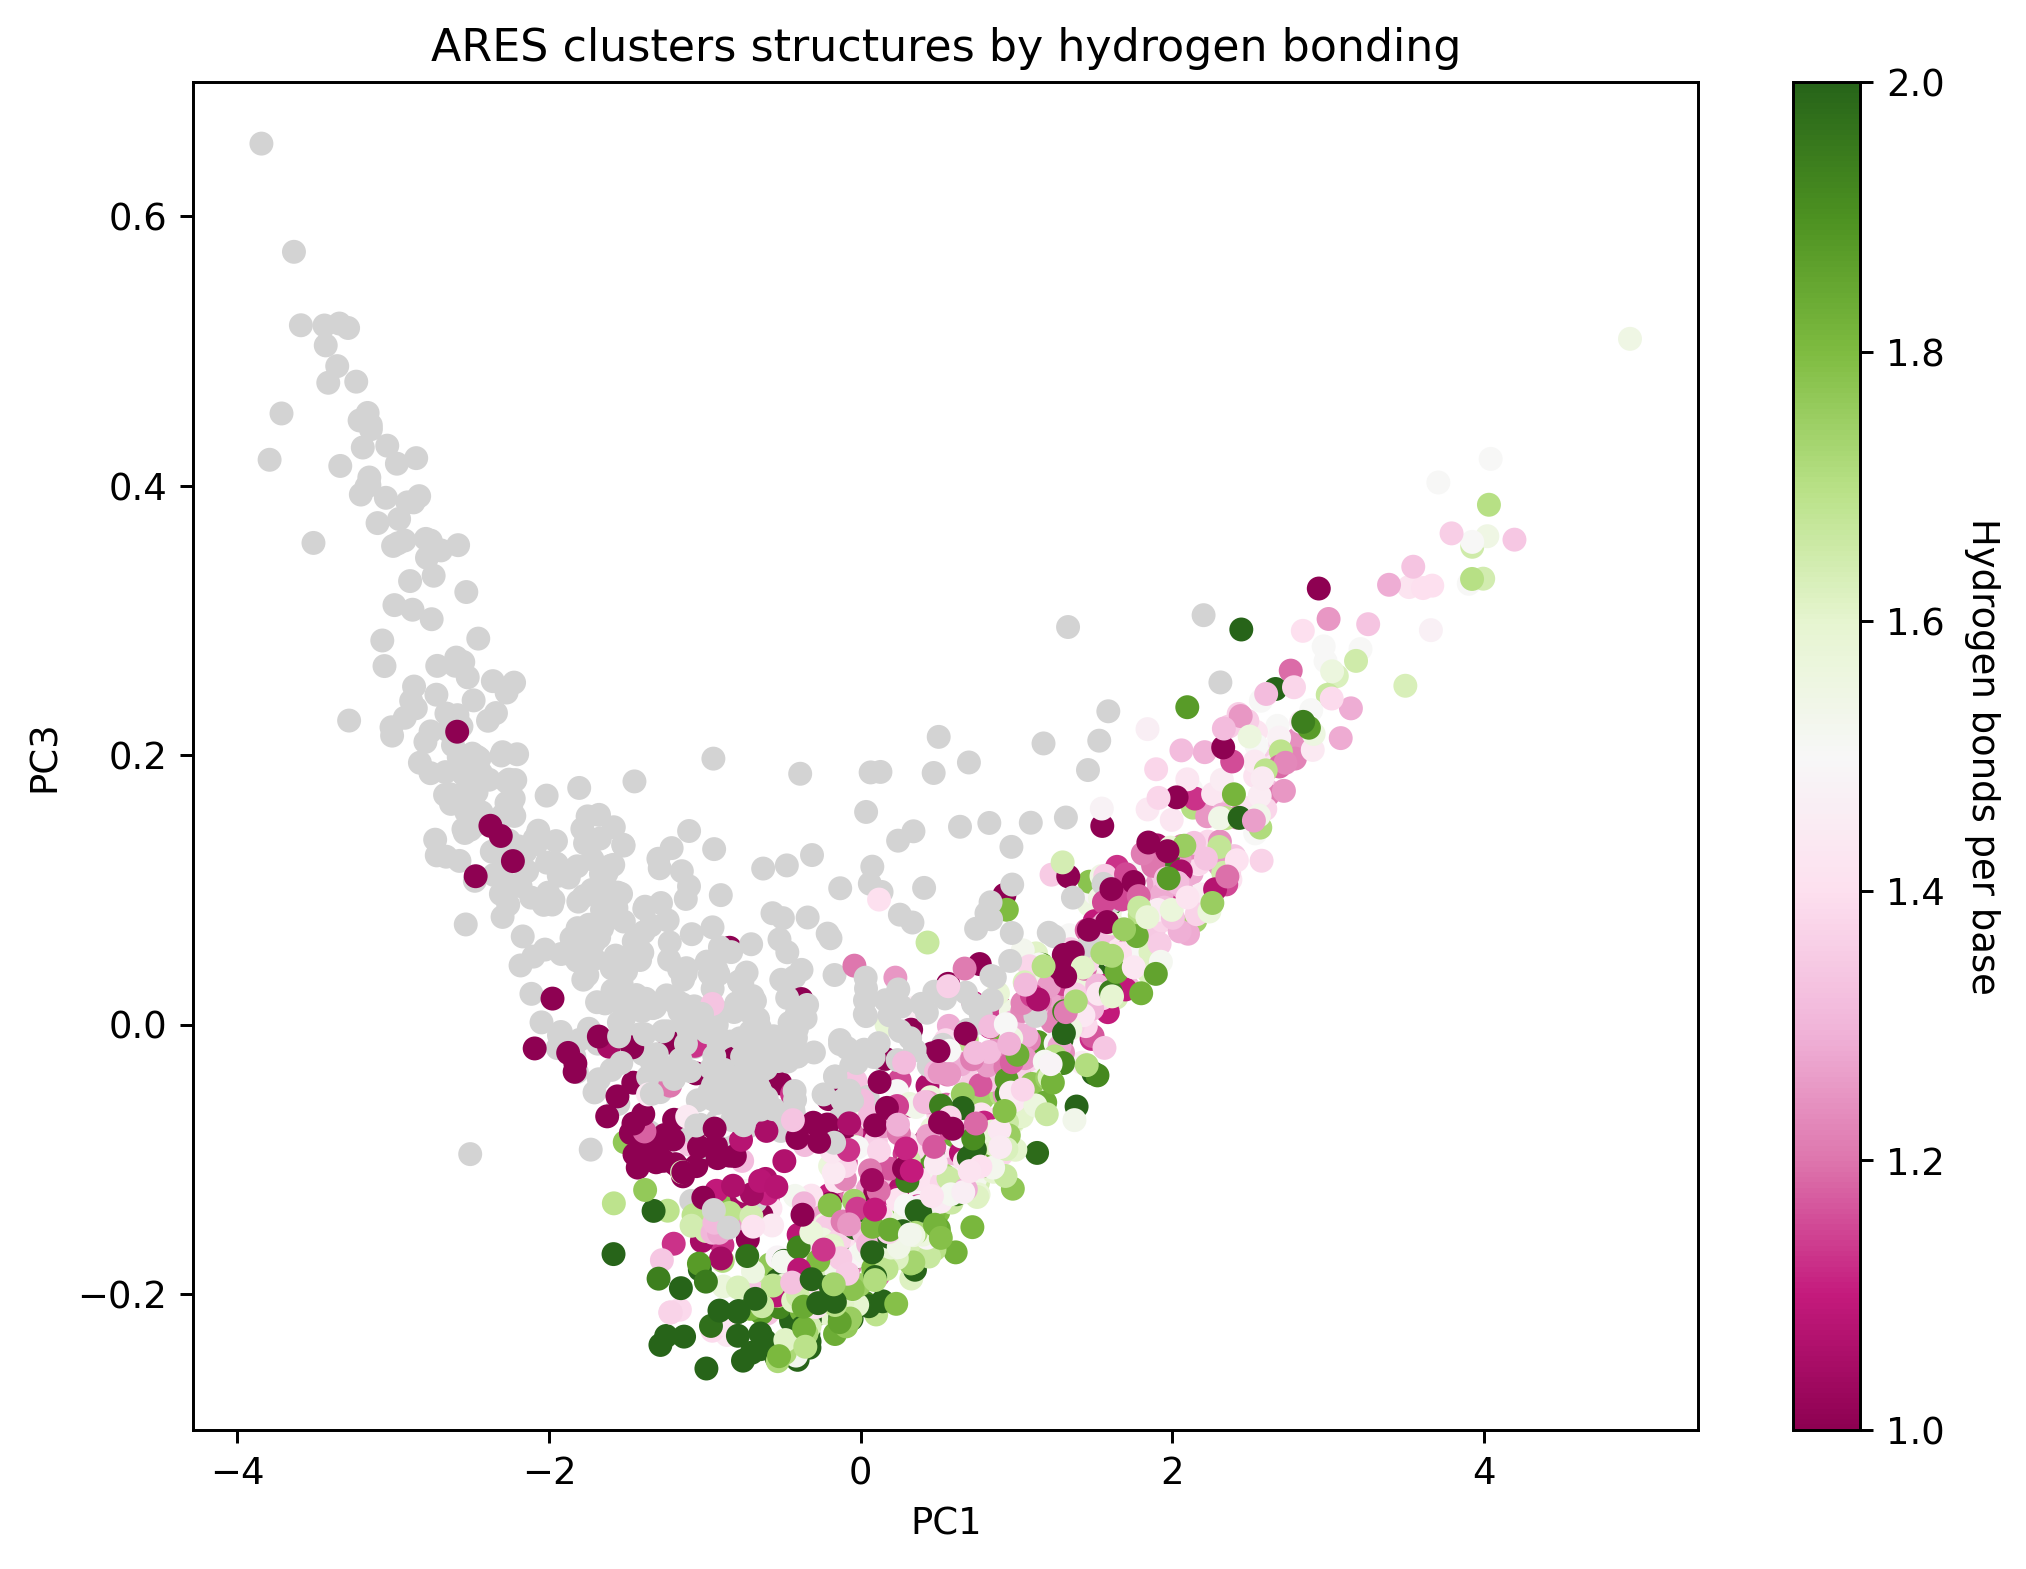

In [6]:
# Plot hydrogen bonding PCA.
(x, y, z) = ('y_pca0', 'y_pca2', 'num_hbonds_norm_nts')

norm = plt.Normalize(1, 2)
cmap = cm.get_cmap('PiYG')

sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
fig = plt.figure(figsize=(8, 6),dpi=266)
ax = plt.gca()
fig.patch.set_alpha(0)
c = np.array([cmap(norm(v)) for v in final[z]])

# If no base pairing, then no hydrogen bonds really.  
# We remove structures with no base pairing as this is not the trend we want to show.
c[final['num_WC_norm_nts'] == 0] = mcolors.to_rgba('lightgray')

ax.scatter(x=final[x], y=final[y], s=30, c=c, cmap=cmap, norm=norm) 

ax.tick_params(labelsize=10)
cbar = plt.colorbar(sm, ax=ax)
cbar.ax.get_yaxis().labelpad = 15
cbar.set_label('Hydrogen bonds per base', rotation=270)

ax.set_xlabel('PC1')
ax.set_ylabel('PC3')

plt.title('ARES clusters structures by hydrogen bonding')

plt.tight_layout()